In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from unidecode import unidecode
from string import punctuation
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import nltk

%matplotlib inline
# nltk.download('all')

### Carregando os dados

In [2]:
dataset = pd.read_csv('data/imdb-reviews.csv')
dataset

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg
...,...,...,...,...
49454,49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos
49455,49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos
49456,49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos
49457,49459,A Christmas Together actually came before my t...,A Christmas Together realmente veio antes do m...,pos


### Funções

<em>Função para criar e testar o modelo</em>

In [3]:
def create_model(df, x, y):
    # Criando a Bag of Words - Matriz Esparsa
    vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,2))
    bag_of_words = vectorizer.fit_transform(df[x])

    # Separando os dados de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        bag_of_words, df[y], test_size=0.33, random_state=42
    )
    
    # Criando e treinando o modelo
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Fazendo teste básico de acurácia
    accuracy = model.score(X_test, y_test)
    print(accuracy)

<em>Função para gerar visualização das WordClouds</em>

In [4]:
def create_wordcloud(df, column):
    all_words = ' '.join([ text for text in df[column] ])
    
    cloud = WordCloud(width=800, height=500, 
                      max_font_size=110, collocations=False).generate(all_words)

    plt.figure(figsize=(16,8))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### Analisando e tratando os dados

In [5]:
dataset['sentiment'].value_counts()

neg    24765
pos    24694
Name: sentiment, dtype: int64

In [6]:
dataset['_sentiment'] = dataset['sentiment'].apply(lambda x: 1 if x == 'pos' else 0 )
dataset

,id,text_en,text_pt,sentiment,_sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0
...,...,...,...,...,...
49454,49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos,1
49455,49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos,1
49456,49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos,1
49457,49459,A Christmas Together actually came before my t...,A Christmas Together realmente veio antes do m...,pos,1


### Criando Word Clouds
Para visualização das palavras com maior destaque

<strong>Positive Cloud</strong>

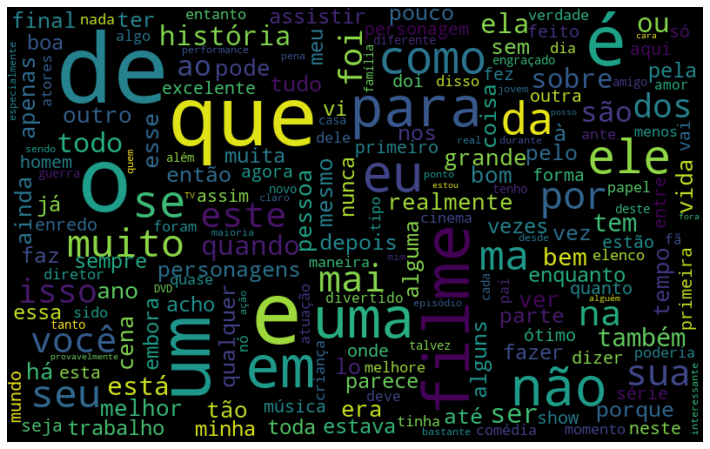

In [7]:
positives = dataset.query('_sentiment == 1')
create_wordcloud(positives, 'text_pt')

<strong>Negative Cloud</strong>

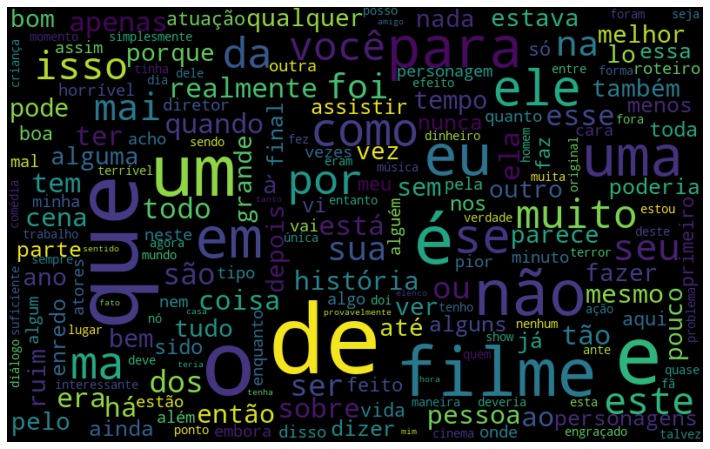

In [8]:
negatives = dataset.query('_sentiment == 0')
create_wordcloud(negatives, 'text_pt')

### Tokenização

In [9]:
# Criando corpus textual com todas as plavras do dataset
all_words = ' '.join([ text for text in dataset['text_pt'] ])

# Criando instância de um WordPunctTokenizer
wpt_tokenizer = nltk.tokenize.WordPunctTokenizer()
word_tokens = wpt_tokenizer.tokenize(all_words)

# Medindo a frequência de cada palavra no corpus
frequency = nltk.FreqDist(word_tokens)

In [10]:
# Criando DataFrame das frequências
frequency_df = pd.DataFrame({'word': frequency.keys(), 'freq': frequency.values()})

In [11]:
# Visualizando palavras com maior frequência
frequency_df.nlargest(columns='freq', n=10)

,word,freq
3,",",611138
6,.,530134
22,de,418565
16,que,330177
44,e,307693
4,o,247255
9,um,217830
101,a,211472
47,é,197337
10,filme,152842


Podemos perceber que <em>as palavras mais frequentes não adicionam muito valor ao texto.</em> 

### Tratando os textos
Removendo Stop Words, Pontuação e Acentuação <br>
Tornando todas as palavras minúsculas

In [12]:
# Removendo acentos e transformando em minúsculo
dataset['refact_text'] = dataset['text_pt'].apply(lambda t: unidecode(t).lower() )

# Importando as Stop Words pelo NLTK, removendo seus acentos e transformando em minúsculo
stop_words = nltk.corpus.stopwords.words('portuguese')
stop_words = [ unidecode(w).lower() for w in stop_words ]

# Adicionando pontuações na lista de Stop Words
stop_words += list(punctuation)

In [13]:
dataset['refact_text'] = dataset['refact_text'].apply( 
    lambda text: ' '.join([ word for word in wpt_tokenizer.tokenize(text) if word not in stop_words ]) 
)
dataset.head()

,id,text_en,text_pt,sentiment,_sentiment,refact_text
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,vez sr costner arrumou filme tempo necessario ...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,exemplo motivo maioria filmes acao mesmos gene...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,beatles puderam escrever musicas todos gostass...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,filmes fotos latao palavra apropriada verdade ...


<strong>Stemização das palavras</strong>

In [14]:
# Instância do stemizador para português
stemmer = nltk.RSLPStemmer()

In [15]:
# Aplicando em todos os textos do dataset
dataset['refact_text'] = dataset['refact_text'].apply( 
    lambda text: ' '.join([ stemmer.stem(word) for word in wpt_tokenizer.tokenize(text) ])
)
dataset.head()

,id,text_en,text_pt,sentiment,_sentiment,refact_text
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,vez sr costn arrum film temp necessari alem te...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,exempl motiv maior film aca mesm gener chat na...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,prim tud odei rap imbecil pod agir arm pressio...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,beatl pud escrev music tod gost emb walt hill ...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,film fot lata palavr apropri verdad tant ous q...


### Word Clouds pós tratamento

<strong>Positive Cloud</strong>

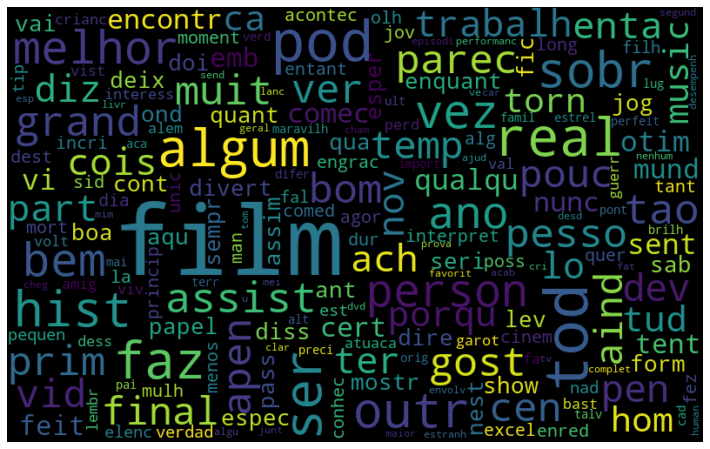

In [16]:
positives = dataset.query('_sentiment == 1')
create_wordcloud(positives, 'refact_text')

<strong>Negative Cloud</strong>

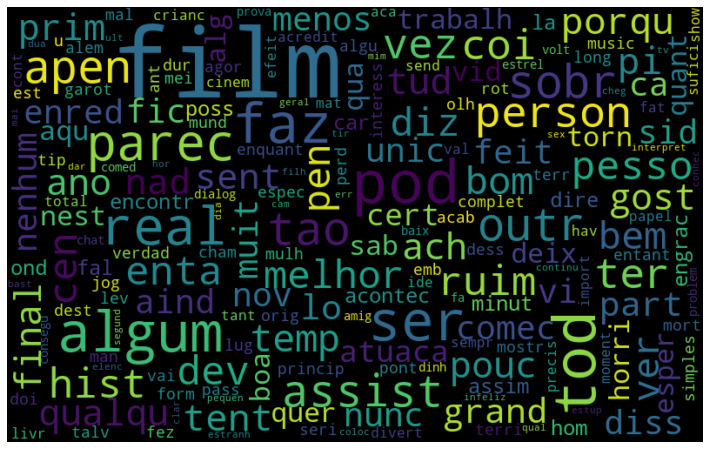

In [17]:
negatives = dataset.query('_sentiment == 0')
create_wordcloud(negatives, 'refact_text')

### Criando modelo

In [18]:
create_model(dataset, 'text_pt', '_sentiment')

0.8863497120450925


In [19]:
create_model(dataset, 'refact_text', '_sentiment')

0.8884327900992526


Realizando os tratamentos no texto observamos ligeira melhora na performance do modelo

<strong>Serializando modelo</strong>

In [22]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,2))
bag_of_words = vectorizer.fit_transform(dataset['refact_text'])
model = LogisticRegression()
model.fit(bag_of_words, dataset['_sentiment'])

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

with open('vectorizer.pickle', 'wb') as f:
    pickle.dump(vectorizer, f)